Major League Baseball Data
--------------------------

In [1]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import seaborn as sns
from sklearn.decomposition import PCA
import scipy.stats as stats

%pylab inline

# http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_MLB_HeightsWeights

Populating the interactive namespace from numpy and matplotlib


In [2]:
# read the csv file into a dataframe
df = pd.read_csv('data/MLB.csv', usecols=range(6)).dropna()

In [3]:
# have a look
df.head()

,Name,Team,Position,Height(inches),Weight(pounds),Age
0,Adam_Donachie,BAL,Catcher,74,180,22.99
1,Paul_Bako,BAL,Catcher,74,215,34.69
2,Ramon_Hernandez,BAL,Catcher,72,210,30.78
3,Kevin_Millar,BAL,First_Baseman,72,210,35.43
4,Chris_Gomez,BAL,First_Baseman,73,188,35.71


In [4]:
# make the column names easier to work with 
df.columns = ['Name', 'Team', 'Position', 'Height', 'Weight', 'Age']
df.head()

,Name,Team,Position,Height,Weight,Age
0,Adam_Donachie,BAL,Catcher,74,180,22.99
1,Paul_Bako,BAL,Catcher,74,215,34.69
2,Ramon_Hernandez,BAL,Catcher,72,210,30.78
3,Kevin_Millar,BAL,First_Baseman,72,210,35.43
4,Chris_Gomez,BAL,First_Baseman,73,188,35.71


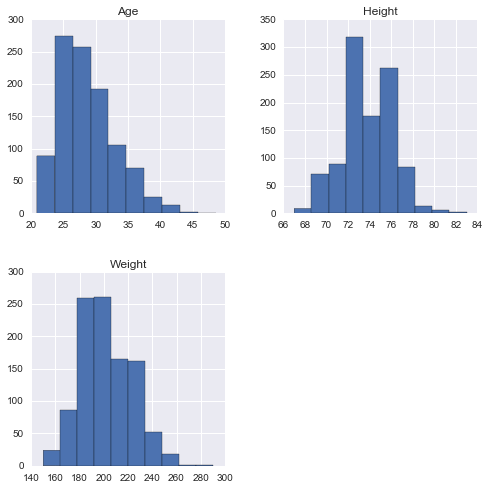

In [5]:
# plot the histograms of the numeric variables
df.hist(figsize=(8,8))
plt.show()

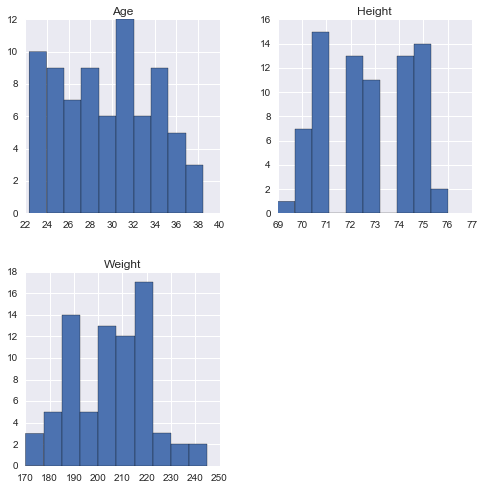

In [6]:
# plot the histograms of the catchers
df[df.Position=='Catcher'].hist(figsize=(8,8), bins=10)
plt.show()

Catchers have relatively flat age distribution, but sharp dropoff. 

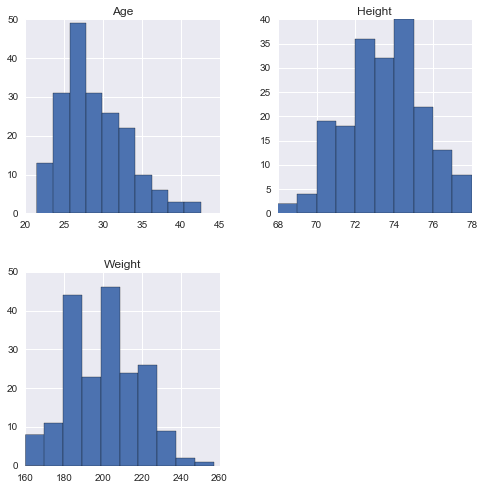

In [7]:
df[df.Position=='Outfielder'].hist(figsize=(8,8))
plt.show()

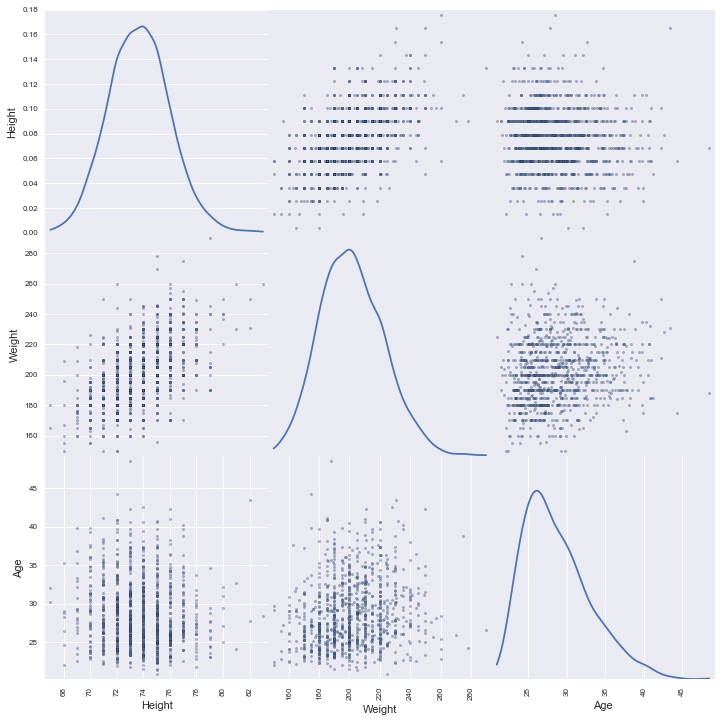

In [8]:
scatter_matrix(df, figsize=(12,12), diagonal='kde')
plt.show()

## Linear regression

We will use the `stats.linregress` function to find the best fit line, plot it, and display a numerical measure of the goodness of fit (R-squared) on the plot. 

R-squared is defined as 

\begin{equation}
R^2 = 1 - \frac{SS_{res}}{SS_{tot}}
\end{equation}

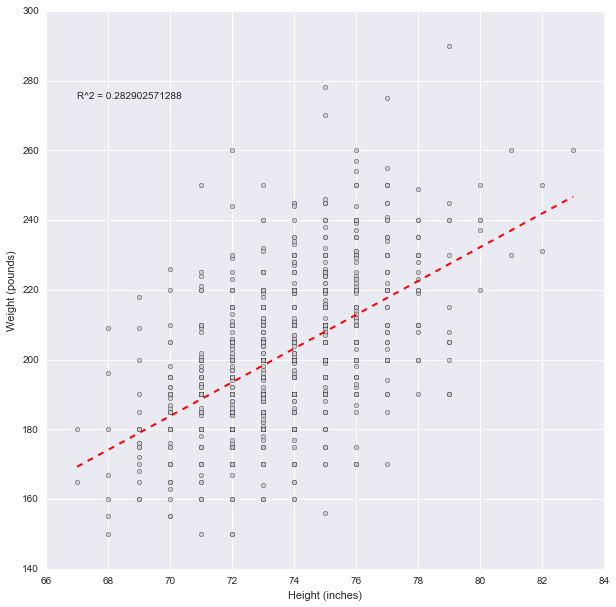

In [9]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df.Height, df.Weight)

x = np.linspace(df.Height.min(), df.Height.max())
plt.figure(figsize=(10,10))
plt.scatter(df.Height, df.Weight, c='0.8')
plt.plot(x, slope*x + intercept, 'r--', lw=2)
plt.xlabel('Height (inches)'), plt.ylabel('Weight (pounds)')
plt.gca().text(67,275,'R^2 = '+str(r_value**2))
# plt.gca().text(67,270,'S_est = '+str(std_err))

## Principal Components Analysis

It would be nice to see the relationship among all three variables. Let's try Principal Component Analysis. 

Principal components analysis involves performing an eigenvalue decomposition of the covariance matrix over the dimensions (not observations). An eigenvector of a matrix $A$ satisfies

\begin{equation}
A \boldsymbol{v} = \lambda \boldsymbol{v}
\end{equation}

Where $\lambda$ is scalar and $\boldsymbol{v}$ is an eigenvector of matrix $A$. 

Let's start by constructing the covariance matrix of the dimensions `Height`, `Weight`, and `Age`. 

In [10]:
cov_matrix = np.cov(df[['Height','Weight','Age']], rowvar=0)

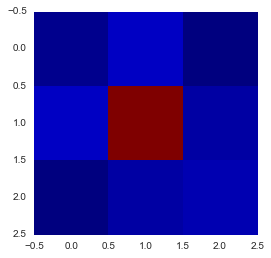

In [11]:
plt.imshow(cov_matrix, interpolation='nearest', cmap='jet')
plt.grid('off')

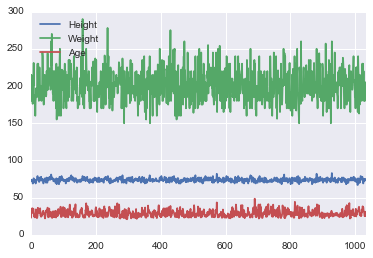

In [12]:
df.plot()

Let's normalize the data before we move on. 

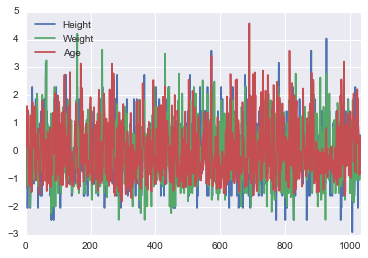

In [13]:
df_normalized = (
                (df[['Height', 'Weight', 'Age']] - 
                 df[['Height', 'Weight', 'Age']].mean()) /
                 df[['Height', 'Weight', 'Age']].std()
                )

df_normalized.plot()

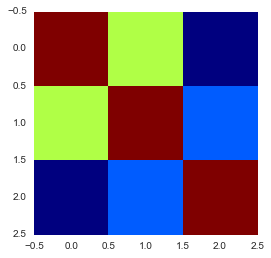

In [14]:
cov_matrix = np.cov(df_normalized, rowvar=0)
plt.imshow(cov_matrix, interpolation='nearest', cmap='jet')
plt.grid('off')

In [15]:
eig_values, eig_vectors = np.linalg.eig(cov_matrix)
eig_values, eig_vectors

(array([ 0.42129716,  1.53882489,  1.03987795]),
 array([[ 0.66948986, -0.68975544, -0.27571861],
        [-0.6903396 , -0.71478158,  0.11188624],
        [ 0.27425273, -0.11543278,  0.95470452]]))

The principal components are sorted according to their eigenvalues, each of which represents the amount of variance accounted for by its associated eigenvectors. According to numpy documentation, the eigenvectors are contained in the `columns` of the returned matrix. 

They are not sorted, so lets sort them. 

In [16]:
eig_vectors = np.array([v[1] for v in sorted(zip(eig_values, eig_vectors.transpose()), reverse=True)]).transpose()
eig_values = sorted(eig_values, reverse=True)

eig_values, eig_vectors

([1.5388248933692741, 1.039877949717821, 0.42129715691289382],
 array([[-0.68975544, -0.27571861,  0.66948986],
        [-0.71478158,  0.11188624, -0.6903396 ],
        [-0.11543278,  0.95470452,  0.27425273]]))

Let's look at the eigenvectors and interpret them. 

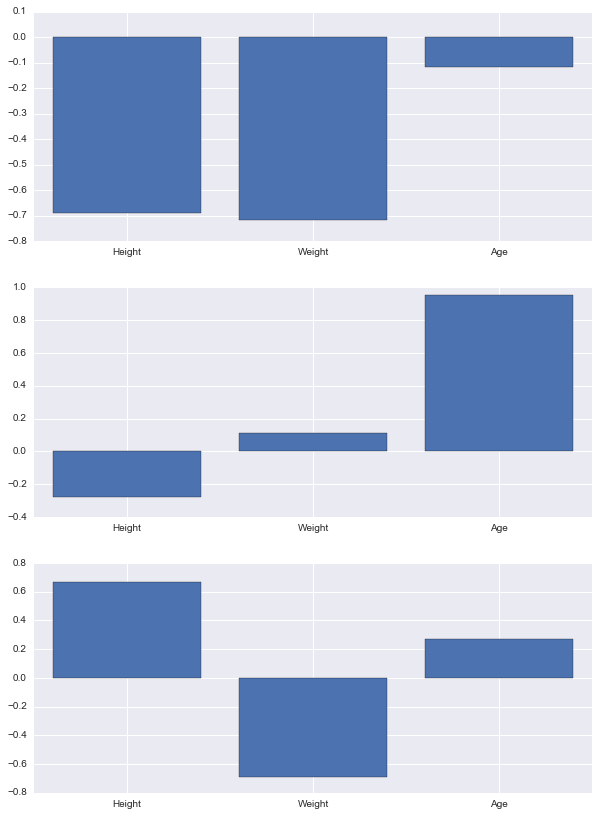

In [17]:
fig, ax = plt.subplots(3,1, figsize=(10,14))

for i in range(3):
    ax[i].bar([0.1,1.1,2.1], eig_vectors[:,i])
    ax[i].set_xticks([0.5, 1.5, 2.5])
    ax[i].set_xticklabels(['Height', 'Weight', 'Age'])

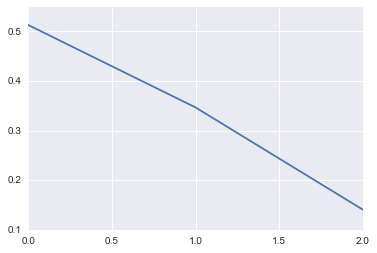

In [18]:
plt.plot(eig_values / sum(eig_values))

We can project our original datapoints into the new space by multiplying the (normalized) data points through our eigenvectors matrix.

In [19]:
projected_points = np.dot(df_normalized, eig_vectors)

projected_points

array([[ 0.80200014, -1.42113152,  0.43598879],
       [-0.70224963,  1.34970459,  0.02732932],
       [ 0.17056853,  0.69851493, -0.63689703],
       ..., 
       [-0.40709984, -0.92149465,  0.04369798],
       [-0.05176553,  0.28406958,  0.90628053],
       [ 0.45864327, -0.1326986 , -0.03478267]])

Each column contains the value of each point along the associated principal component. Let's plot the first two. 

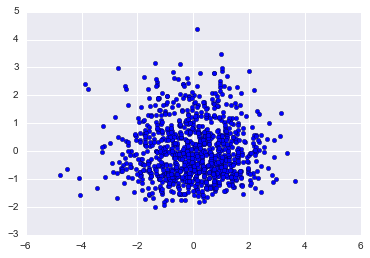

In [20]:
plt.scatter(projected_points[:,0], projected_points[:,1])

Let's append the projected points of the first two principle components on the original dataframe, then save it as a file. 

In [21]:
df['PC1'] = projected_points[:,0]
df['PC2'] = projected_points[:,1]

Let's also plot each position on its own

In [22]:
x_min, x_max = df.PC1.min(), df.PC1.max()
y_min, y_max = df.PC2.min(), df.PC2.max()

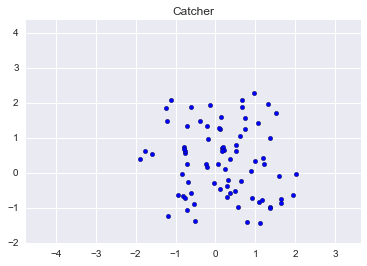

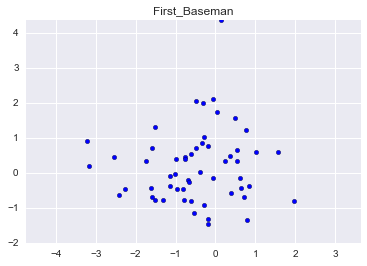

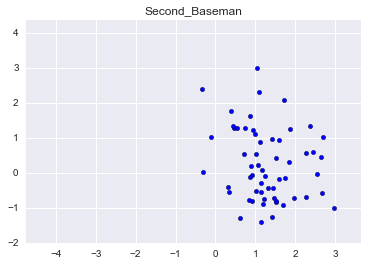

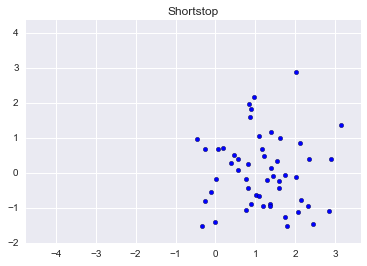

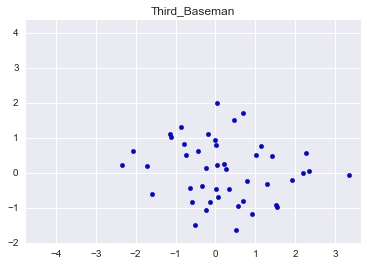

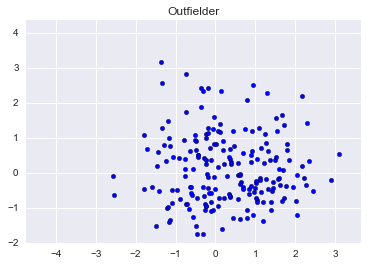

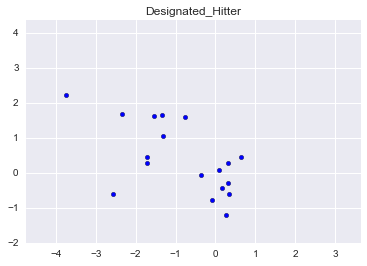

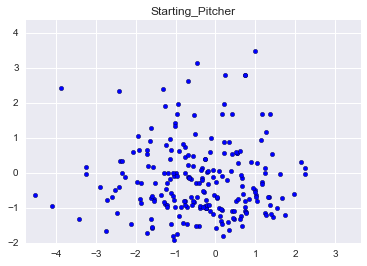

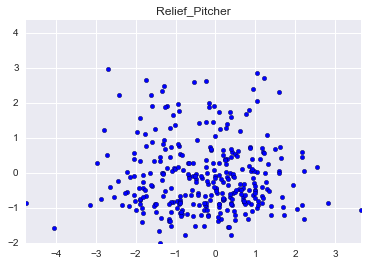

In [23]:
for position in df.Position.unique():
    plt.figure()
    plt.scatter(df[df.Position == position]['PC1'], df[df.Position == position]['PC2'])
    plt.title(position)
    plt.xlim((x_min, x_max))
    plt.ylim((y_min, y_max))

Let's save the dataframe that has the principal component coordinates as a `.csv` file. 

In [24]:
df.to_csv('data/MLB_2.csv')